In [1]:
import pandas as pd
df = pd.read_parquet('./data/SSE50_20050104_20230406')
df

,open,high,low,close,vol,amount
trade_time,,,,,,
2005-01-04,836.9900,836.9900,824.010,827.0700,4.031697e+08,2.136409e+09
2005-01-05,825.7100,836.4300,822.970,831.4300,3.020863e+08,1.705649e+09
2005-01-06,831.9900,833.0700,820.340,822.5000,2.753574e+08,1.519687e+09
2005-01-07,822.6700,832.9500,819.440,823.6200,3.066086e+08,1.640665e+09
2005-01-10,823.7700,833.6500,821.000,832.9900,2.479411e+08,1.402314e+09
...,...,...,...,...,...,...
2023-03-30,2639.3600,2665.3400,2628.100,2664.2100,3.361247e+09,5.917679e+10
2023-03-31,2670.9500,2681.8200,2657.770,2661.9200,2.888886e+09,5.641443e+10
2023-04-03,2667.1800,2673.6600,2655.070,2665.7200,3.526984e+09,6.817447e+10


In [81]:
mean_list=df[:int(len(df)*0.7)].mean().values
std_list=df[:int(len(df)*0.7)].std().values
df=(df-mean_list)/std_list
df

,open,high,low,close,vol,amount
trade_time,,,,,,
2005-01-04,-1.850790,-1.862309,-1.861274,-1.866691,-0.926308,-0.959709
2005-01-05,-1.865298,-1.863023,-1.862628,-1.861081,-0.960705,-0.969831
2005-01-06,-1.857221,-1.867304,-1.866051,-1.872572,-0.969801,-0.974201
2005-01-07,-1.869208,-1.867457,-1.867222,-1.871131,-0.959166,-0.971358
2005-01-10,-1.867793,-1.866565,-1.865192,-1.859073,-0.979130,-0.976959
...,...,...,...,...,...,...
2023-03-30,0.467334,0.467209,0.486786,0.497379,0.080287,0.380629
2023-03-31,0.507963,0.488207,0.525403,0.494432,-0.080451,0.315719
2023-04-03,0.503114,0.477810,0.521889,0.499322,0.136685,0.592057


In [3]:
import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

start_date='2005-1-1'
## End Date
end_date='2022-12-31'
## Split ratio of train data and validation data
train_rate=0.7
## How many business days to see
observation_period_num=64
## How many business days to predict
predict_period_num=1

# Parameter for mdoel
## Learning Rate
lr=0.00005
## Epoch Number
epochs=1000
## Mini-Batch size
batch_size=64
## How many epochs to stop train if valid loss is not decreasing
patience=20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Array initialization
in_data=[]
out_data=[]
# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
  data=df.iloc[i:i+observation_period_num,2:].values
  label=df.iloc[i+predict_period_num:i+observation_period_num+predict_period_num,3].values
  in_data.append(data)
  out_data.append(label)
in_data=torch.FloatTensor(in_data)
out_data=torch.FloatTensor(out_data)

train_data_in=in_data[:int(np.shape(in_data)[0]*train_rate)].to(device)
train_data_out=out_data[:int(np.shape(out_data)[0]*train_rate)].to(device)
valid_data_in=in_data[int(np.shape(in_data)[0]*train_rate):].to(device)
valid_data_out=out_data[int(np.shape(out_data)[0]*train_rate):].to(device)


/var/folders/rc/d92q64ds74d0jg428sqj64lc0000gn/T/ipykernel_30982/3474657634.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  in_data=torch.FloatTensor(in_data)


In [23]:
valid_data_out.shape

torch.Size([1312, 64])

In [5]:
# Define a function for getting mini-batch
def get_batch(data_in, data_out, i, batch_size):
  seq_len=min(batch_size, len(data_in)-1-i)
  input=data_in[i:i+seq_len]
  target=data_out[i:i+seq_len]
  return input, target

In [6]:
# Functions for positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len=5000):
    super().__init__()
    self.dropout=nn.Dropout(p=0.1)
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0)/d_model))
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)
    pe=pe.unsqueeze(0).transpose(0,1)
    self.register_buffer("pe",pe)
  
  def forward(self,x):
    return self.dropout(x+self.pe[:np.shape(x)[0],:])

In [7]:
# Transformer model definition
class TransformerModel(nn.Module):
  def __init__(self,feature_size=4,num_layers=1,dropout=0.1):
    super().__init__()
    self.model_type='Transformer'
    self.src_mask=None
    self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.pos_encoder=PositionalEncoding(d_model=feature_size)
    self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=2,dropout=dropout)
    self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
    self.decoder=nn.Linear(feature_size,1)
  
  def init_weights(self):
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform(-0.1,0.1)

  def _generate_square_subsequent_mask(self,sz):
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

  def forward(self,src):
    if self.src_mask is None or self.src_mask.size(0)!=len(src):
      device=self.device
      mask=self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask=mask
    src=self.pos_encoder(src)
    output=self.transformer_encoder(src,self.src_mask)
    output=self.decoder(output)
    return output

In [8]:
# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf
        
    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score<self.best_score:
            self.counter+=1
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

/opt/anaconda3/envs/kchart_learning/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 10:epoch | 0.01062707 : train loss | 1.303002 : valid loss
 20:epoch | 0.009794083 : train loss | 1.182175 : valid loss
 30:epoch | 0.009457395 : train loss | 1.147087 : valid loss
 40:epoch | 0.009314364 : train loss | 1.126616 : valid loss
 50:epoch | 0.009241225 : train loss | 1.113821 : valid loss
 60:epoch | 0.009189825 : train loss | 1.105588 : valid loss
 70:epoch | 0.00917546 : train loss | 1.101522 : valid loss
 80:epoch | 0.009145556 : train loss | 1.098428 : valid loss
 90:epoch | 0.009141682 : train loss | 1.096704 : valid loss
100:epoch | 0.009127372 : train loss | 1.095583 : valid loss
110:epoch | 0.00913287 : train loss | 1.094907 : valid loss
120:epoch | 0.009143752 : train loss | 1.094546 : valid loss
130:epoch | 0.009104853 : train loss | 1.094311 : valid loss
140:epoch | 0.009148487 : train loss | 1.094169 : valid loss
150:epoch | 0.009137431 : train loss | 1.094083 : valid loss
160:epoch | 0.009137319 : train loss | 1.094045 : valid loss
170:epoch | 0.009114765 : t

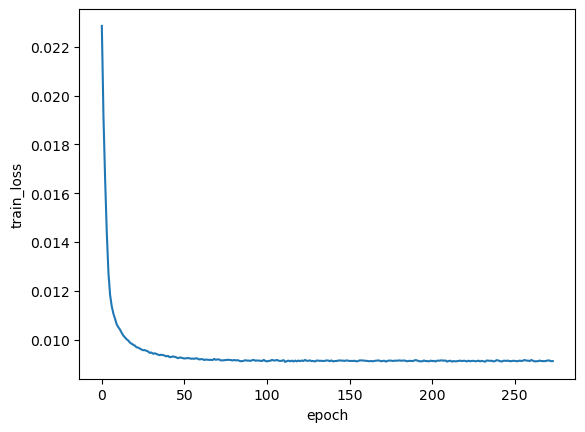

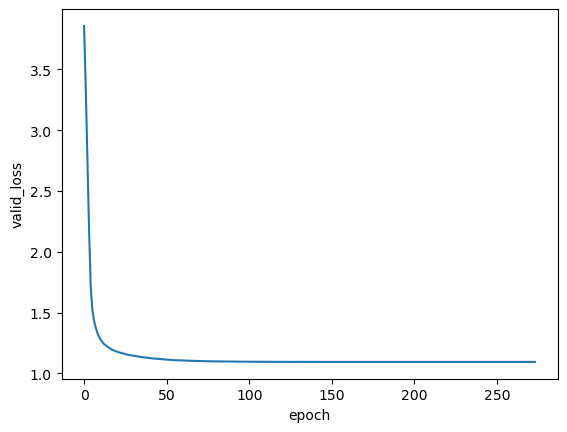

In [9]:
model=TransformerModel().to(device)
criterion=nn.MSELoss()

optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.95)
earlystopping=EarlyStopping(patience)

train_loss_list=[]
valid_loss_list=[]

for epoch in range(1,epochs+1):
  # train
  model.train()
  total_loss_train=0.0
  for batch, i in enumerate(range(0,len(train_data_in),batch_size)):
    data,targets=get_batch(train_data_in, train_data_out, i, batch_size)
    if(data.shape[0] < 64):
      break
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,targets)
    loss.backward()
    optimizer.step()
    total_loss_train+=loss.item()
  scheduler.step()
  total_loss_train=total_loss_train/len(train_data_in)
#valid
  model.eval()
  total_loss_valid=0.0
  for i in range(0,len(valid_data_in),batch_size):
    data,targets=get_batch(valid_data_in, valid_data_out,i,batch_size)
    output=model(data)
    if(data.shape[0] < 64):
      break
    total_loss_valid+=len(data[0])*criterion(output, targets).cpu().item()
  total_loss_valid=total_loss_valid/len(valid_data_in)

  #etc
  train_loss_list.append(total_loss_train)
  valid_loss_list.append(total_loss_valid)
  if epoch%10==0:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
  earlystopping((total_loss_valid),model)
  if earlystopping.early_stop:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    print("Early Stop")
    break

plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

In [10]:
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)

with torch.no_grad():
  for i in range(0,len(valid_data_in)-1):
    data,target=get_batch(valid_data_in,valid_data_out,i,1)
    output=model(data)
    result=torch.cat((result, output[-1].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-1].view(-1).cpu()),0)


In [26]:
result_ = (result.reshape(-1, 64)).numpy()

In [86]:
result_ 

array([[0.45422992, 0.47094914, 0.47300813, ..., 0.29413906, 0.3481075 ,
        0.5482452 ],
       [0.47094914, 0.47300813, 0.35580638, ..., 0.3481075 , 0.5482452 ,
        0.32163098],
       [0.47300813, 0.35580638, 0.27298123, ..., 0.5482452 , 0.32163098,
        0.40952584],
       ...,
       [0.2460961 , 0.39240393, 0.29734126, ..., 0.15705517, 0.26482865,
        0.26456252],
       [0.39240393, 0.29734126, 0.35135725, ..., 0.26482865, 0.26456252,
        0.13340464],
       [0.29734126, 0.35135725, 0.3325692 , ..., 0.26456252, 0.13340464,
        0.16895685]], dtype=float32)

result_ 

In [88]:
pos = np.sum(np.diff(result_, axis=1)[:, :3], axis=1, keepdims=True)/result_[:, :1]
pos[pos < 0] = 0
pos[pos > 1] = 1
pos = pos.ravel()

In [71]:
df.index[-len(pos):]

DatetimeIndex(['2017-11-14', '2017-11-15', '2017-11-16', '2017-11-17',
               '2017-11-20', '2017-11-21', '2017-11-22', '2017-11-23',
               '2017-11-24', '2017-11-27',
               ...
               '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28',
               '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03',
               '2023-04-04', '2023-04-06'],
              dtype='datetime64[ns]', name='trade_time', length=1311, freq=None)

In [62]:
len(result)

83904

累计收益率: 1.4977485197193112
夏普比率: 0.5910711913651012


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

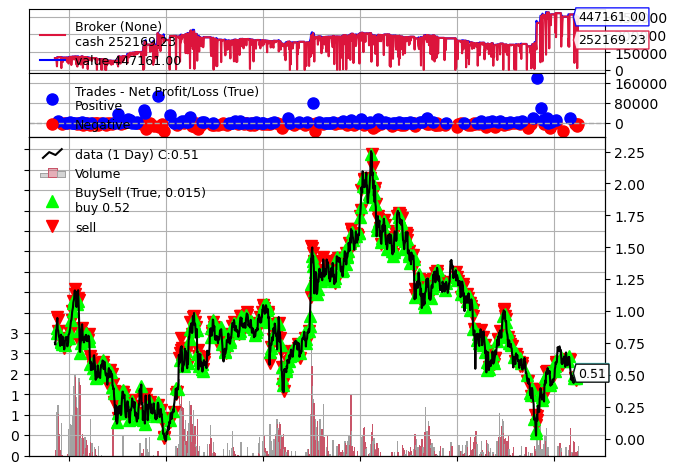

In [ ]:
%matplotlib inline
import backtrader as bt
import pandas as pd

# Strategy definition
class PositionStrategy(bt.Strategy):
    params = (('positions', []),) # a list of positions for each time step

    def __init__(self):
        self.counter = 0 # use a counter to track the current time step

    def next(self):
        if self.counter < len(self.params.positions):
            position = self.params.positions[self.counter]# 获取当前时间步的仓位 # get the position for the current time step
            size = position * self.broker.get_cash() / self.data.close[0] # calculate the number of shares to buy based on the position

            # adjust the position based on the target size
            self.order_target_size(target=size)
            
        self.counter += 1

# load data
data = bt.feeds.GenericCSVData(
    dataname='./data.csv',
    fromdate=pd.Timestamp('2017-11-14'),
    todate=pd.Timestamp('2023-04-06'),
    nullvalue=0.0,
    dtformat=('%Y-%m-%d'),
    datetime=0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5
)

# initialize the backtesting system
cerebro = bt.Cerebro()
positions = pos # Example position list, adjust according to actual situation
cerebro.addstrategy(PositionStrategy, positions=positions)
cerebro.adddata(data)

# Set initial cash
cerebro.broker.setcash(100000.0)

# Add performance analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# Run the backtest
results = cerebro.run()
strat = results[0]


print('累计收益率:', strat.analyzers.returns.get_analysis()['rtot']) # Total return
print('夏普比率:', strat.analyzers.sharpe.get_analysis()['sharperatio']) # sharpe ratio

plt.figure()
cerebro.plot()


In [90]:
strat.analyzers.returns.get_analysis()

OrderedDict([('rtot', 1.4977485197193112),
             ('ravg', 0.0011433194807017643),
             ('rnorm', 0.33391270808846324),
             ('rnorm100', 33.39127080884632)])